In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive_output, FloatSlider, HBox, VBox, Label, Layout, Output
from IPython.display import display, clear_output
from trainers.trainer import standalone, centralized, fedavg, bruteforce, eval_local
from utils.synthetic.data_generator import Data_Generator

def create_combined_data(global_data):
    combined_data = {
        'A0': {'x': [], 'y': [], 's': []},
        'A1': {'x': [], 'y': [], 's': []},
        'B0': {'x': [], 'y': [], 's': []},
        'B1': {'x': [], 'y': [], 's': []}}
    for data in global_data:
        if data is not None:
            for group in ['A0', 'A1', 'B0', 'B1']:
                combined_data[group]['x'].extend(data[group]['x'])
                combined_data[group]['y'].extend(data[group]['y'])
                combined_data[group]['s'].extend(data[group]['s'])
    return combined_data

def convert_xys(data):
    x, y, s = [], [], []
    for group in ['A0', 'A1', 'B0', 'B1']:
        x.extend(data[group]['x'])
        y.extend(data[group]['y'])
        s.extend(data[group]['s'])  
    return np.array(x), np.array(y), np.array(s)

In [2]:
#data generation
data1 = Data_Generator(100000, 0.5, 0.5, 0.5, [6.0, 0, 2.0, -6.0], [1.0, 1.0, 1.0, 1.0])
data2 = Data_Generator(100000, 0.5, 0.5, 0.5, [6.0, -2.0, 2.0, -6.0], [1.0, 1.0, 1.0, 1.0])

In [ ]:
#How many iteration does centralized model take to converge?
global_data = [data1.get_client(), data2.get_client()]
combined_data = create_combined_data(global_data)
x, y, s = convert_xys(combined_data)
global_epochs = [100,200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]

for epoch in global_epochs:
    centralized_result = centralized(combined_data, 0.1, epoch)
    print("centralized", epoch, centralized_result[3], centralized_result[0])

bf_result = bruteforce(x, y, s, 1.0, 0.001, warm_start=centralized_result[3])
print("bf", bf_result[3], bf_result[0])

centralized 0.24783725267078507 0.93804 0.20674000000000003 0.12391999999999997


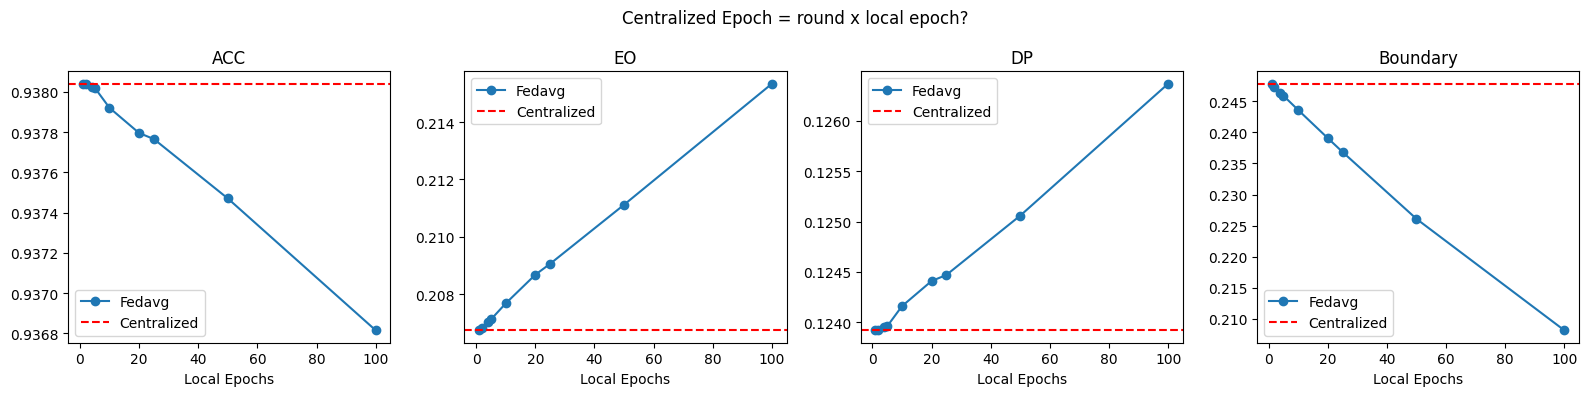

In [4]:
#Centralized epoch = round * local epoch?
import matplotlib.pyplot as plt

global_data = [data1.get_client(), data2.get_client()]
combined_data = create_combined_data(global_data)
x, y, s = convert_xys(combined_data)
local_epochs = [1, 2, 4, 5, 10, 20, 25, 50, 100]
centralized_result = centralized(combined_data, 0.1, 100)

print("centralized", centralized_result[3], centralized_result[0], centralized_result[1], centralized_result[2])

results = []

for epoch in local_epochs:
    fedavg_result = fedavg(combined_data, global_data, 0.1, int(100/epoch), [0.1, 0.1], [epoch, epoch])
    results.append(fedavg_result)
results = np.array(results)


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(local_epochs, results[:, 0],marker='o', label='Fedavg')
axs[0].axhline(y=centralized_result[0], color='r', linestyle='--', label='Centralized') 
axs[0].set_title('ACC')
axs[0].set_xlabel('Local Epochs')
axs[0].legend() 

axs[1].plot(local_epochs, results[:, 1],marker='o',label='Fedavg')
axs[1].axhline(y=centralized_result[1], color='r', linestyle='--', label='Centralized') 
axs[1].set_title('EO')
axs[1].set_xlabel('Local Epochs')
axs[1].legend() 

axs[2].plot(local_epochs, results[:, 2],marker='o',label='Fedavg')
axs[2].axhline(y=centralized_result[2], color='r', linestyle='--', label='Centralized') 
axs[2].set_title('DP')
axs[2].set_xlabel('Local Epochs')
axs[2].legend() 

axs[3].plot(local_epochs, results[:, 3],marker='o',label='Fedavg')
axs[3].axhline(y=centralized_result[3], color='r', linestyle='--', label='Centralized') 
axs[3].set_title('Boundary')
axs[3].set_xlabel('Local Epochs')
axs[3].legend() 

fig.suptitle('Centralized Epoch = round x local epoch?')
plt.tight_layout()
plt.show()

centralized 0.682125608205364 0.945055 0.12370000000000003 0.10988999999999999


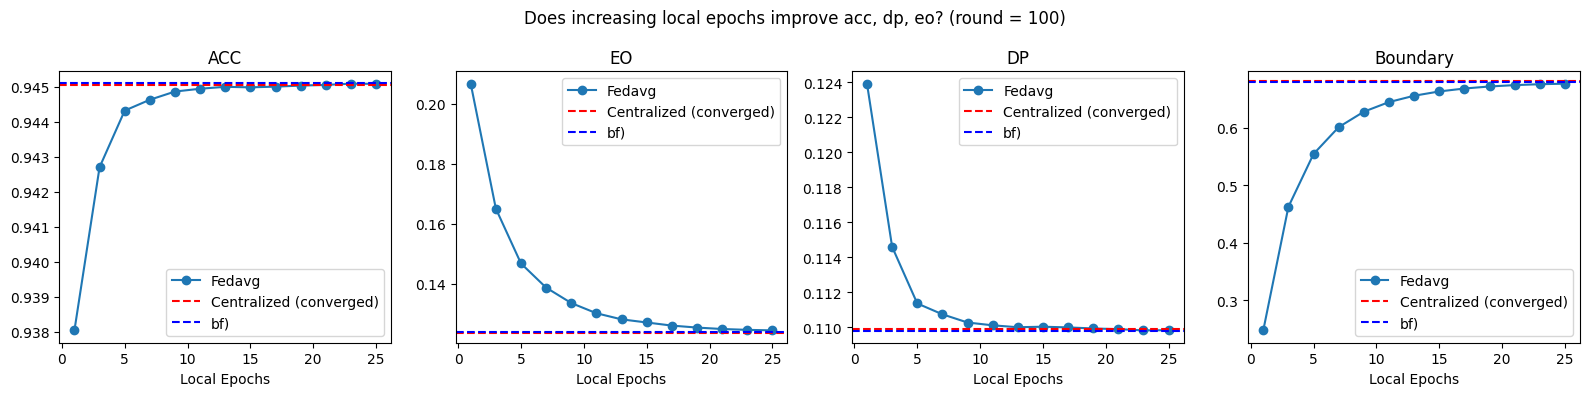

In [42]:
#Does increasing local epochs improve (acc, dp, eo)?
import matplotlib.pyplot as plt

global_data = [data1.get_client(), data2.get_client()]
combined_data = create_combined_data(global_data)
x, y, s = convert_xys(combined_data)
#local_epochs = list(range(1, 201, 10))
local_epochs = list(range(1, 26, 2))

centralized_result = centralized(combined_data, 0.1, 2000)
bf_result = bruteforce(x, y, s, 1.0, 0.001, warm_start=centralized_result[3])
print("centralized", centralized_result[3], centralized_result[0], centralized_result[1], centralized_result[2])

results = []

for epoch in local_epochs:
    fedavg_result = fedavg(combined_data, global_data, 0.1, 100, [0.1, 0.1], [epoch, epoch])
    results.append(fedavg_result)
results = np.array(results)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(local_epochs, results[:, 0],marker='o', label='Fedavg')
axs[0].axhline(y=centralized_result[0], color='r', linestyle='--', label='Centralized (converged)') 
axs[0].axhline(y=bf_result[0], color='b', linestyle='--', label='bf)') 
axs[0].set_title('ACC')
axs[0].set_xlabel('Local Epochs')
axs[0].legend() 

axs[1].plot(local_epochs, results[:, 1],marker='o',label='Fedavg')
axs[1].axhline(y=centralized_result[1], color='r', linestyle='--', label='Centralized (converged)') 
axs[1].axhline(y=bf_result[1], color='b', linestyle='--', label='bf)') 
axs[1].set_title('EO')
axs[1].set_xlabel('Local Epochs')
axs[1].legend() 

axs[2].plot(local_epochs, results[:, 2],marker='o',label='Fedavg')
axs[2].axhline(y=centralized_result[2], color='r', linestyle='--', label='Centralized (converged)') 
axs[2].axhline(y=bf_result[2], color='b', linestyle='--', label='bf)') 
axs[2].set_title('DP')
axs[2].set_xlabel('Local Epochs')
axs[2].legend() 

axs[3].plot(local_epochs, results[:, 3],marker='o',label='Fedavg')
axs[3].axhline(y=centralized_result[3], color='r', linestyle='--', label='Centralized (converged)') 
axs[3].axhline(y=bf_result[3], color='b', linestyle='--', label='bf)') 
axs[3].set_title('Boundary')
axs[3].set_xlabel('Local Epochs')
axs[3].legend() 

fig.suptitle('Does increasing local epochs improve acc, dp, eo? (round = 100)')
plt.tight_layout()
plt.show()
    